In [1]:
import pandas as pd 
import numpy as np
from time import time
import seaborn as sns

In [2]:
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import pyplot

import sys
import warnings
warnings.filterwarnings("ignore")

## Dataset

In this section we import our dataset (already processed and encoded) and check for correlated variables

The features we are interested in have to be as independent as possible from each other. Therefore, we are going to
make sure that we don't have any correlated columns with a value higher than .95

In [3]:
#dataset_original = pd.read_csv(r'..\reports\provisional.csv', index_col = 0)
dataset_original = pd.read_csv(r'Definitive_ML_Data.csv', index_col = 0)
dataset_original = dataset_original.dropna()
dataset = dataset_original.copy()

In [4]:
dataset

,Away_team,division,matchday,result_home,season,team,GD_home,Pts_difference,home_rank
1,Arenas Club,1,1,W,1928-1929,Athletic Madrid,0.0,3.0,4
2,Real Unión,1,1,W,1928-1929,Espanyol,0.0,3.0,3
4,Catalunya,1,1,W,1928-1929,Real Madrid,0.0,3.0,1
1,Athletic,1,1,T,1928-1929,Donostia,0.0,-2.0,5
2,Racing,1,1,W,1928-1929,Barcelona,0.0,3.0,2
...,...,...,...,...,...,...,...,...,...
47993,Ponferradina,2,3,L,2021-2022,Girona,2.0,0.0,13
47997,SD Amorebieta,2,3,L,2021-2022,UD Almería,3.0,5.0,5
47992,Real Valladolid,2,3,L,2021-2022,CD Lugo,0.0,-5.0,17
47992,Real Sociedad B,2,3,T,2021-2022,CF Fuenlabrada,1.0,0.0,12


In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

categorical_variables = ["season", "team", "Away_team", "result_home"]

for col in categorical_variables:
    dataset[f"{col}_encoded"] = le.fit_transform(dataset[col])

In [6]:
dataset = dataset.drop(['result_home','Away_team',"team","season"], axis=1)
dataset

,division,matchday,GD_home,Pts_difference,home_rank,season_encoded,team_encoded,Away_team_encoded,result_home_encoded
1,1,1,0.0,3.0,4,0,12,7,2
2,1,1,0.0,3.0,3,0,68,115,2
4,1,1,0.0,3.0,1,0,110,56,2
1,1,1,0.0,-2.0,5,0,66,11,1
2,1,1,0.0,3.0,2,0,23,102,2
...,...,...,...,...,...,...,...,...,...
47993,2,3,2.0,0.0,13,90,75,96,0
47997,2,3,3.0,5.0,5,90,136,120,0
47992,2,3,0.0,-5.0,17,90,36,116,0
47992,2,3,1.0,0.0,12,90,49,114,1


In [7]:
cor_matrix = dataset.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)  



[]


<AxesSubplot:>

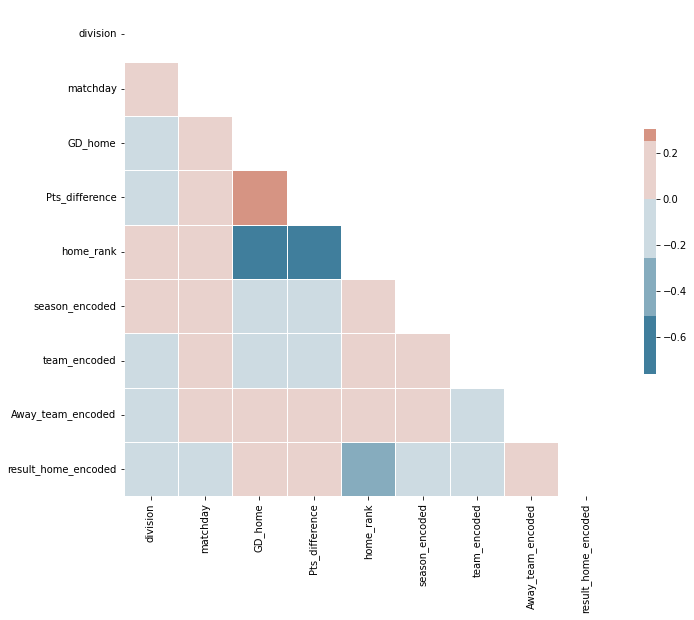

In [8]:
# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=False)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Normal selection of variables and splitting data

In [9]:
dataset = dataset.dropna()
target = dataset.result_home_encoded
features = ['division','matchday','GD_home','Pts_difference','home_rank','season_encoded','team_encoded','Away_team_encoded']
X = dataset[features]
#X = dataset[['season','division','matchday','team','Away_team','W','GD_cum_before','rank_before']]
X_train,X_test,y_train,y_test = train_test_split(X, target, test_size=0.2, random_state=1, stratify=target)

## Function to construct confusion matrix and ROC

In [10]:
#plot our results
def confusion_matrix(trained_model, y_test, X_test):
    Y_test_pred = trained_model.predict(X_test)

    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        title="Confusion Matrix",
                                        cmap="Oranges",
                                        ax=ax1)

    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        ax=ax2)

def ROC_PRC_matrix(trained_model, y_test, X_test):    
    y_test_probs = trained_model.predict_proba(X_test)
    
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_roc_curve(y_test, y_test_probs,
                       title="Digits ROC Curve", figsize=(12,6), ax=ax1)
    
    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_precision_recall_curve(y_test, y_test_probs,
                        title="Digits Precision-Recall Curve", figsize=(12,6), ax= ax2)

## Estimations of parameters in models

In [20]:
# Looking for best parameter for logistic regression model
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    logreg = LogisticRegression(C=C).fit(X_train, y_train)
    prediction_in = logreg.predict(X_train)
    accuracy_f1_in = f1_score(y_train, prediction_in, average="weighted")
    prediction_out = logreg.predict(X_test)
    accuracy_f1_out = f1_score(y_test, prediction_out, average="weighted")
    print() 
    print("Logistic Regression with parameter ", C) 
    print("-" * 30)
    print("Accuracy on training set: ",logreg.score(X_train, y_train), "\tf1 training set: ", accuracy_f1_in )
    print("Accuracy on test set: ",logreg.score(X_test, y_test), "\tf1 test set: ", accuracy_f1_out )



Logistic Regression with parameter  0.001
------------------------------
Accuracy on training set:  0.5173821989528796 	f1 training set:  0.4887653469692314
Accuracy on test set:  0.5211518324607329 	f1 test set:  0.4915077443623607

Logistic Regression with parameter  0.01
------------------------------
Accuracy on training set:  0.5172774869109947 	f1 training set:  0.48891580945512214
Accuracy on test set:  0.5225130890052356 	f1 test set:  0.4936465531338285

Logistic Regression with parameter  0.1
------------------------------
Accuracy on training set:  0.5159424083769634 	f1 training set:  0.4877339720739352
Accuracy on test set:  0.5211518324607329 	f1 test set:  0.4921300675600489

Logistic Regression with parameter  1
------------------------------
Accuracy on training set:  0.5175392670157068 	f1 training set:  0.48891046667745064
Accuracy on test set:  0.5206282722513089 	f1 test set:  0.4909713126044269

Logistic Regression with parameter  10
-----------------------------

In [21]:
# Preprunning for decision tree model, avoiding overfitting
for depth in range(3,8):
    tree = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    prediction_in = tree.predict(X_train)
    accuracy_f1_in = f1_score(y_train, prediction_in, average="weighted")
    prediction_out = tree.predict(X_test)
    accuracy_f1_out = f1_score(y_test, prediction_out, average="weighted")
    print() 
    print("Decision tree with depth ", depth) 
    print("-" * 30)
    print("Accuracy on training set: ",tree.score(X_train, y_train), "\tf1 training set: ", accuracy_r2_in )
    print("Accuracy on test set: ",tree.score(X_test, y_test), "\tf1 test set: ", accuracy_r2_out )



Decision tree with depth  3
------------------------------
Accuracy on training set:  0.49856020942408374 	f1 training set:  0.5248730335007484
Accuracy on test set:  0.4918324607329843 	f1 test set:  0.5131393184574335

Decision tree with depth  4
------------------------------
Accuracy on training set:  0.5208638743455497 	f1 training set:  0.5248730335007484
Accuracy on test set:  0.5128795811518324 	f1 test set:  0.5131393184574335

Decision tree with depth  5
------------------------------
Accuracy on training set:  0.5343717277486911 	f1 training set:  0.5248730335007484
Accuracy on test set:  0.5260732984293194 	f1 test set:  0.5131393184574335

Decision tree with depth  6
------------------------------
Accuracy on training set:  0.5397905759162304 	f1 training set:  0.5248730335007484
Accuracy on test set:  0.5306806282722513 	f1 test set:  0.5131393184574335

Decision tree with depth  7
------------------------------
Accuracy on training set:  0.5524607329842932 	f1 training 

In [22]:
# Random forest model
for trees in range(5,10):
    for depth in range(2,6):
        random_forest = RandomForestClassifier(max_depth=depth, n_estimators=trees, max_features=3).fit(X_train, y_train)
        prediction_in = random_forest.predict(X_train)
        accuracy_f1_in = f1_score(y_train, prediction_in, average='weighted')
        prediction_out = random_forest.predict(X_test)
        accuracy_f1_out = f1_score(y_test, prediction_out, average='weighted')
        print() 
        print(f"Random_forest with {trees} trees and {depth} depth") 
        print("-" * 40)
        print("Accuracy on training set: ",random_forest.score(X_train, y_train), "\tf1 training set: ", accuracy_f1_in )
        print("Accuracy on test set: ",random_forest.score(X_test, y_test), "\tf1 test set: ", accuracy_f1_out )



Random_forest with 5 trees and 2 depth
----------------------------------------
Accuracy on training set:  0.4943717277486911 	f1 training set:  0.4222928018711955
Accuracy on test set:  0.4918324607329843 	f1 test set:  0.42030675859600697

Random_forest with 5 trees and 3 depth
----------------------------------------
Accuracy on training set:  0.5264659685863874 	f1 training set:  0.471990098629878
Accuracy on test set:  0.5164397905759163 	f1 test set:  0.4636556382105553

Random_forest with 5 trees and 4 depth
----------------------------------------
Accuracy on training set:  0.5284816753926701 	f1 training set:  0.47490295298868956
Accuracy on test set:  0.5282722513089005 	f1 test set:  0.4775692867223567

Random_forest with 5 trees and 5 depth
----------------------------------------
Accuracy on training set:  0.5371204188481675 	f1 training set:  0.4983275679494064
Accuracy on test set:  0.5286910994764398 	f1 test set:  0.4923625998395711

Random_forest with 6 trees and 2 d

As we can see, the best results are obtained for the following metrics: 
- Random Forest with 7 trees and 5 depth
- Logistic Regression with the parameter 0.01
- Decision Tree with deph 7

Now we will decide which one to choose. 


Logistic Regression
--------------------
Accuracy on training set:  0.5403141361256545 	f1 training set:  0.48734049200977714
Accuracy on test set:  0.5339267015706807 	f1 test set:  0.4896246160890367

Decision Tree
--------------------
Accuracy on training set:  0.5403141361256545 	f1 training set:  0.5248730335007484
Accuracy on test set:  0.5339267015706807 	f1 test set:  0.5131393184574335

Random Forest
--------------------
Accuracy on training set:  0.5403141361256545 	f1 training set:  0.48379450151121467
Accuracy on test set:  0.5339267015706807 	f1 test set:  0.482137804841755


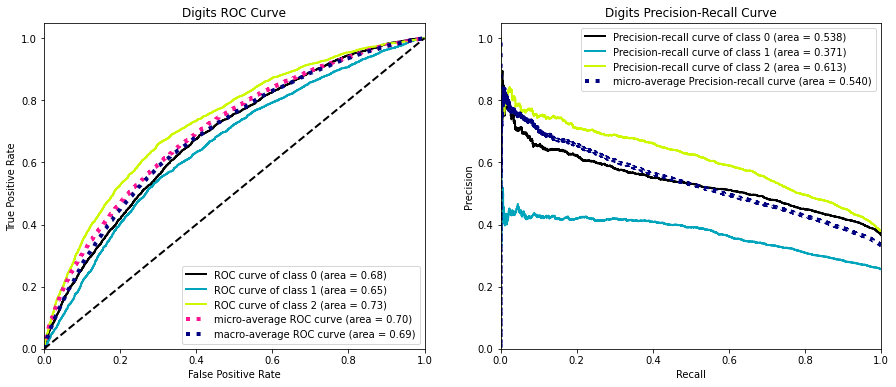

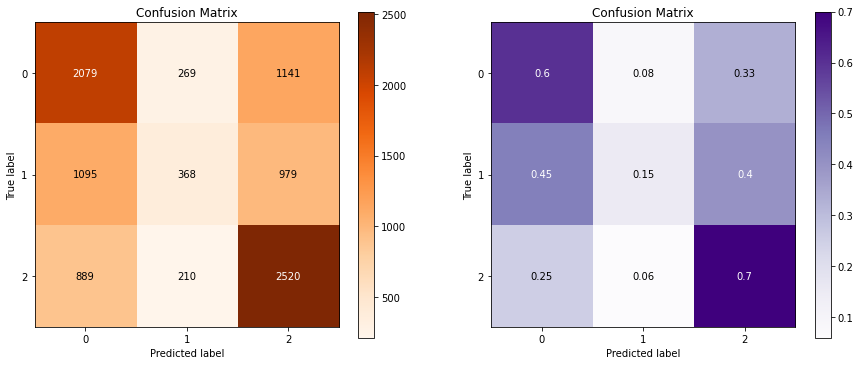

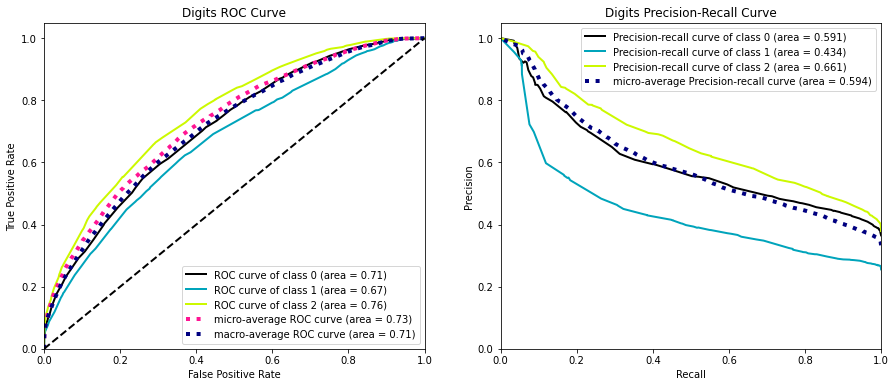

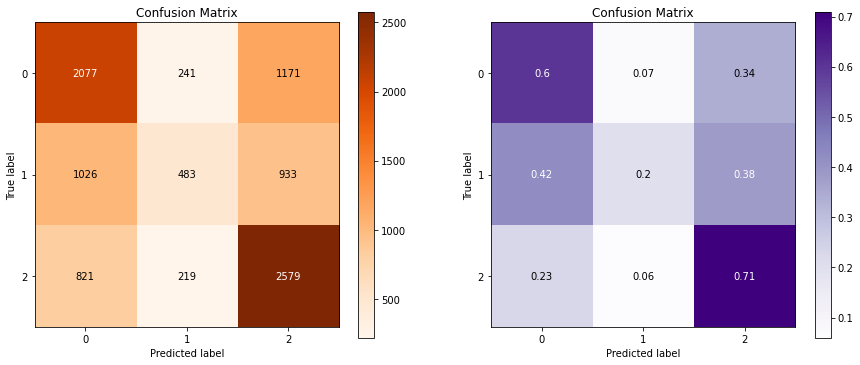

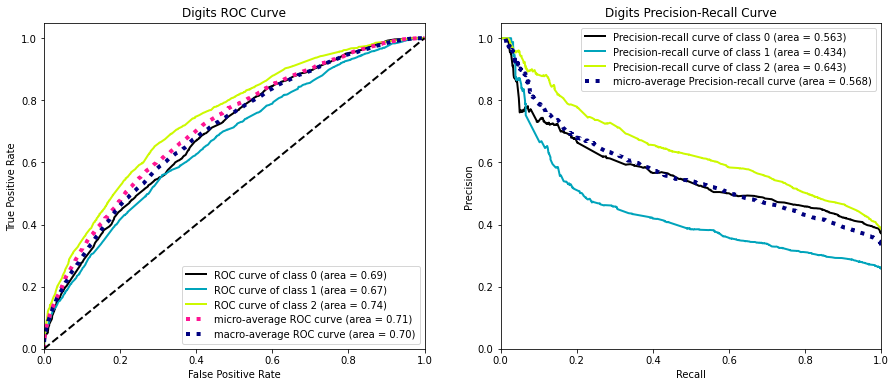

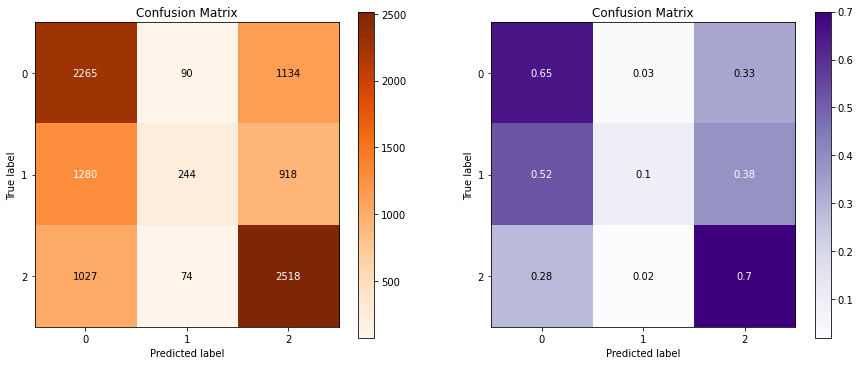

In [24]:
names = ["Logistic Regression", "Decision Tree", "Random Forest"]
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

classifiers = [
    #KNeighborsClassifier(3),
    LogisticRegression(solver='sag', multi_class='auto', max_iter=1000, C=100),
    DecisionTreeClassifier(max_depth=7),
    RandomForestClassifier(max_depth=5, n_estimators=5, max_features=3),
]

for name, clf in zip(names, classifiers):
        #model = OneVsOneClassifier(clf).fit(X_train, y_train)
        model = clf.fit(X_train, y_train)
        prediction_in = model.predict(X_train)
        accuracy_f1_in = f1_score(y_train, prediction_in, average='weighted')
        prediction_out = model.predict(X_test)
        accuracy_f1_out = f1_score(y_test, prediction_out, average='weighted')
        print() 
        print(name) 
        print("-" * 20)
        print("Accuracy on training set: ",random_forest.score(X_train, y_train), "\tf1 training set: ", accuracy_f1_in )
        print("Accuracy on test set: ",random_forest.score(X_test, y_test), "\tf1 test set: ", accuracy_f1_out )
        ROC_PRC_matrix(model, y_test, X_test)
        confusion_matrix(model, y_test, X_test)


## Selected Best Model: 
- Desition tree model with depth 7 , acc = 0.5381151832460733

## Model analysis, features importance

<AxesSubplot:>

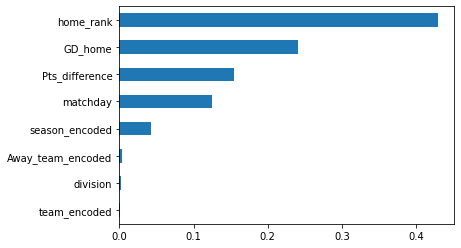

In [26]:
tree = DecisionTreeClassifier(max_depth=7).fit(X_train, y_train)
importances = pd.Series(tree.feature_importances_, index=features)
importances.sort_values(ascending=True).plot(kind="barh")

## Undoing the encoding 


In [ ]:
result_in = le.inverse_transform(prediction_in).tolist()
result_out = le.inverse_transform(prediction_out).tolist()
result = result_in + result_out

In [ ]:
dataset_original['Predictions'] = result

In [ ]:
dataset_original.to_csv(r'../reports/Results.csv')